필수 요소 설치

In [1]:
!pip install metrics
!pip install scipy==1.2

     |████████████████████████████████| 849kB 2.8MB/s 
  Created wheel for metrics: filename=metrics-0.3.3-py2.py3-none-any.whl size=17814 sha256=3bf79428a61eb99b421ed7100e13354327eda3fd29ba4b318ca6af89b8d5c7f4
  Stored in directory: /root/.cache/pip/wheels/38/e8/55/c4c648451a33a60920318eba4c5735088dbf78dc20d4277db0
  Created wheel for pathspec: filename=pathspec-0.5.5-cp37-none-any.whl size=24235 sha256=fd6c4ff778a30eba54798040f386d99e38b2a47ba46eda9517e1cd4fe04f1575
  Stored in directory: /root/.cache/pip/wheels/d1/2e/6b/c67842adf3b13ea33ca3fe6a2a963622821ad647db724688e2
Successfully built metrics pathspec
ERROR: jupyterlab-pygments 0.1.2 has requirement pygments<3,>=2.4.1, but you'll have pygments 2.2.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1


     |████████████████████████████████| 26.6MB 160kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
%pylab inline
import os
import keras
import metrics
import numpy as np
import pandas as pd
import keras.backend as K
import scipy.misc
import imageio

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


경로 지정 및 구글 드라이브에 연동

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
root_dir = os.path.abspath('./gdrive/My Drive/deep')
data_dir = os.path.join(root_dir, 'data')

데이터 불러오기

In [6]:
train = pd.read_csv(os.path.join(data_dir, 'filename2.csv'))

train.head()

,filename
0,cafe_1001_0.jpg
1,cafe_1001_1.jpg
2,cafe_1001_10.jpg
3,cafe_1001_11.jpg
4,cafe_1001_2.jpg


In [7]:
print(data_dir)

/content/gdrive/My Drive/deep/data


In [ ]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(data_dir, color_mode='rgb', class_mode='input',
                                                    target_size=(180,180), batch_size=256)



Found 0 images belonging to 0 classes.


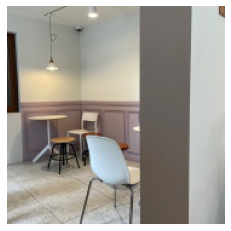

In [8]:
img_name = random.choice(train.filename)
filepath = os.path.join(root_dir, 'data', img_name)

img = imageio.imread(filepath, as_gray=False, pilmode="RGB")

pylab.imshow(img, cmap='jet')
pylab.axis('off')
pylab.show()

In [9]:
temp = []
for img_name in train.filename :
  image_path = os.path.join(data_dir, img_name)
  img = imageio.imread(image_path)
  img = img.astype('float32')
  temp.append(img)

In [10]:
print(temp[0].shape)
print(len(temp[1].shape))

(180, 180, 3)
3


In [11]:
train_x = np.stack(temp)

train_x /=  255.0
train_x = train_x.reshape(-1,180*180*3 ).astype('float32')

train set과 validation set 나누기

In [12]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:] 

dec 모델 구성

In [13]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        3D tensor with shape: `(n_samples, n_features, n_channel)`.
    # Output shape
        3D tensor with shape: `(n_samples, n_clusters, n_channel)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape = (self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='./gdrive/My Drive/results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./gdrive/My Drive/results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred



하이퍼 파라미터 설정

In [14]:
# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 2e4
tol = 0.001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 10
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


cluster = 10으로 dec모델 학습

In [15]:
# prepare the DEC model
dec = DEC(dims=[train_x.shape[-1], 500, 500, 2000, 10], n_clusters=10, init=init)

dec.pretrain(x=train_x, y=None, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/10
2/2 [==============================] - 34s 2s/step - loss: 0.2546
Epoch 2/10
2/2 [==============================] - 20s 883ms/step - loss: 0.2528
Epoch 3/10
2/2 [==============================] - 18s 858ms/step - loss: 0.2510
Epoch 4/10
2/2 [==============================] - 18s 885ms/step - loss: 0.3187
Epoch 5/10
2/2 [==============================] - 18s 881ms/step - loss: 0.2393
Epoch 6/10
2/2 [==============================] - 18s 880ms/step - loss: 0.1747
Epoch 7/10
2/2 [==============================] - 18s 908ms/step - loss: 0.1223
Epoch 8/10
2/2 [==============================] - 18s 907ms/step - loss: 0.1763
Epoch 9/10
2/2 [==============================] - 18s 862ms/step - loss: 0.1191
Epoch 10/10
2/2 [==============================] - 17s 906ms/step - loss: 0.0951
Pretraining time:  196.76386499404907
Pretrained weights are saved to results/ae_weights.h5


### 적절한 군집 개수 구하기
  

# 1.   elbow 기법



In [16]:
def elbow(train_x):
  sse=[]
  for i in range(2,15):
    km = KMeans(n_clusters = i, init='k-means++', random_state=0)
    km.fit(train_x)
    sse.append(km.inertia_)
  
  plt.plot(range(2,15), sse, marker='o')
  plt.xlabel('클러스터 개수')
  plt.ylabel('SSE')
  plt.show()


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

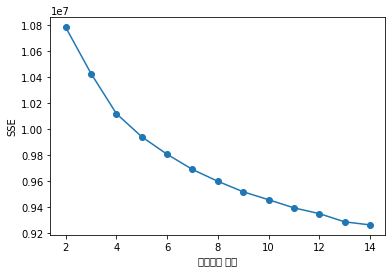

In [17]:
elbow(train_x)

cluster 4가 적절

# 2. 실루엣 기법

In [18]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def plotSilhouette(train_x, y_km):
  cluster_labels = np.unique(y_km)
  n_clusters = cluster_labels.shape[0]
  silhouette_vals = silhouette_samples(train_x, y_km, metric='euclidean')
  y_ax_lower, y_ax_upper = 0, 0
  yticks=[]

  for i,c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km ==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i/n_clusters)

    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper)/2)
    y_ax_lower += len(c_silhouette_vals)

  silhoutte_avg = np.mean(silhouette_vals)
  plt.axvline(silhoutte_avg, color='red', linestyle='--')
  plt.yticks(yticks, cluster_labels+1)
  plt.ylabel('클러스터')
  plt.xlabel('실루엣 계수')
  plt.show()


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50659 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53364 missing from current font.
  font.set_

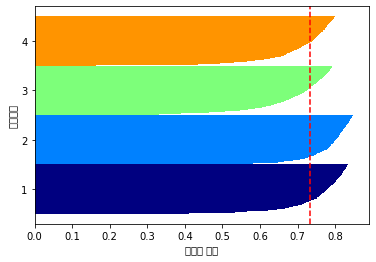

In [20]:
from sklearn.datasets import make_blobs
train_x, y = make_blobs(n_samples = len(train_x), centers = 4, cluster_std = 0.5, 
                  shuffle = True, random_state=0)
km = KMeans(n_clusters=4, random_state=0)
y_km = km.fit_predict(train_x)
plotSilhouette(train_x, y_km)

In [24]:
from sklearn.metrics import silhouette_score
score = silhouette_score(train_x, y_km, metric='euclidean')
score 

0.7345376746309881

결과로 나온 적절한 클러스터 개수로 dec 학습하기

In [25]:
dec = DEC(dims=[train_x.shape[-1], 500, 500, 2000, 10], n_clusters=4, init=init)

dec.pretrain(x=train_x, y=None, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)
dec.model.summary()
dec.compile(optimizer=SGD(0.01,0.9), loss='kld')


...Pretraining...
Epoch 1/10
2/2 [==============================] - 1s 36ms/step - loss: 12.5553
Epoch 2/10
2/2 [==============================] - 1s 42ms/step - loss: 2.7465
Epoch 3/10
2/2 [==============================] - 1s 34ms/step - loss: 2.6031
Epoch 4/10
2/2 [==============================] - 1s 35ms/step - loss: 8.8726
Epoch 5/10
2/2 [==============================] - 1s 36ms/step - loss: 10.9393
Epoch 6/10
2/2 [==============================] - 1s 34ms/step - loss: 10.7183
Epoch 7/10
2/2 [==============================] - 1s 34ms/step - loss: 7.7108
Epoch 8/10
2/2 [==============================] - 1s 35ms/step - loss: 3.4362
Epoch 9/10
2/2 [==============================] - 1s 36ms/step - loss: 1.9147
Epoch 10/10
2/2 [==============================] - 1s 36ms/step - loss: 1.8838
Pretraining time:  6.69236159324646
Pretrained weights are saved to results/ae_weights.h5
Model: "model_1"
_________________________________________________________________
Layer (type)             

In [26]:
dec.fit(train_x)

Update interval 140
Save interval 41.015625
Initializing cluster centers with k-means.
saving model to: ./gdrive/My Drive/results/temp/DEC_model_0.h5
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: ./gdrive/My Drive/results/temp/DEC_model_final.h5


array([1, 0, 2, ..., 0, 3, 0])

In [ ]:
import h5py

filename = "DEC_model_final.h5"

f = h5py.File('./gdrive/My Drive/results/temp/DEC_model_final.h5', 'r')


OSError: ignored

In [ ]:
list(f.keys())

['clustering', 'encoder_0', 'encoder_1', 'encoder_2', 'encoder_3', 'input']

In [28]:
file_name_temp=list(train.iloc[:,0])
result=[[file_name_temp[i], y_km[i]]for i in range(len(y_km))]
result[0:10]

[['cafe_1001_0.jpg', 1],
 ['cafe_1001_1.jpg', 2],
 ['cafe_1001_10.jpg', 0],
 ['cafe_1001_11.jpg', 3],
 ['cafe_1001_2.jpg', 2],
 ['cafe_1001_3.jpg', 2],
 ['cafe_1001_4.jpg', 0],
 ['cafe_1001_5.jpg', 1],
 ['cafe_1001_6.jpg', 0],
 ['cafe_1001_7.jpg', 2]]

In [34]:
result[2001:3001]


[['cafe_12_9.jpg', 0],
 ['cafe_1301_0.jpg', 1],
 ['cafe_1301_1.jpg', 3],
 ['cafe_1301_10.jpg', 2],
 ['cafe_1301_11.jpg', 3],
 ['cafe_1301_2.jpg', 3],
 ['cafe_1301_3.jpg', 3],
 ['cafe_1301_4.jpg', 3],
 ['cafe_1301_5.jpg', 0],
 ['cafe_1301_6.jpg', 0],
 ['cafe_1301_7.jpg', 2],
 ['cafe_1301_8.jpg', 2],
 ['cafe_1301_9.jpg', 2],
 ['cafe_1303_0.jpg', 1],
 ['cafe_1303_1.jpg', 3],
 ['cafe_1303_10.jpg', 0],
 ['cafe_1303_11.jpg', 2],
 ['cafe_1303_2.jpg', 0],
 ['cafe_1303_3.jpg', 2],
 ['cafe_1303_4.jpg', 1],
 ['cafe_1303_5.jpg', 0],
 ['cafe_1303_6.jpg', 2],
 ['cafe_1303_7.jpg', 2],
 ['cafe_1303_8.jpg', 0],
 ['cafe_1303_9.jpg', 1],
 ['cafe_1304_0.jpg', 1],
 ['cafe_1304_1.jpg', 3],
 ['cafe_1304_10.jpg', 1],
 ['cafe_1304_2.jpg', 3],
 ['cafe_1304_3.jpg', 0],
 ['cafe_1304_4.jpg', 1],
 ['cafe_1304_5.jpg', 3],
 ['cafe_1304_6.jpg', 1],
 ['cafe_1304_7.jpg', 1],
 ['cafe_1304_8.jpg', 3],
 ['cafe_1304_9.jpg', 2],
 ['cafe_1305_0.jpg', 0],
 ['cafe_1305_1.jpg', 2],
 ['cafe_1305_10.jpg', 0],
 ['cafe_1305_11.jpg',